# Check predictions with a trained model

In [1]:
import sys
sys.path.insert(0, "../code")

In [2]:
data_path = "../input/train_tiles/"
csv_path = "../input/train_tiles/tile_stats.csv"

In [3]:
from dataflow.datasets import get_trainval_datasets

In [4]:
train_folds = [0, 1, 2]
val_folds = [3, ]

train_ds, val_ds = get_trainval_datasets(data_path, csv_path, train_folds=train_folds, val_folds=val_folds)

In [5]:
from dataflow.dataloaders import get_train_val_loaders, get_train_sampler

In [6]:
from dataflow.vis import make_grid

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = (0.0, 0.0, 0.0)
std = (3.0, 3.0, 3.0)
max_value = 1.0

val_transforms = A.Compose([
    A.Normalize(mean=mean, std=std, max_pixel_value=max_value),
    ToTensorV2()
])

Load trained model

In [15]:
import os
os.environ['MLFLOW_TRACKING_URI']="../output/mlruns"

In [16]:
run_uuid = "bf1fa0a668cd4d4da7de6f2c77b6bebb"
weights_filename = "checkpoint_model_28000.pth"

In [37]:
import torch

from models import LWRefineNet
from utils.commons import get_artifact_path

In [18]:
num_classes = 2
model = LWRefineNet(num_channels=3, num_classes=num_classes)
model.load_state_dict(torch.load(get_artifact_path(run_uuid, weights_filename)))

<All keys matched successfully>

In [21]:
model = model.to('cuda')
model.eval();

In [92]:
from pathlib import Path
from dataflow.vis import render_image, render_mask, render_datapoint, default_palette

from ignite.metrics.confusion_matrix import ConfusionMatrix, IoU

preds_palette = (0, 0, 0, 255, 255, 0)

cm = ConfusionMatrix(num_classes=num_classes)
iou_metric = IoU(cm, ignore_index=0)


def to_numpy(y):
    return y[0, :, :].byte().cpu().numpy()


def display_preds(y_preds, y, image):
    _im = render_image(image)

    cm.reset()
    cm.update((y_preds, y))
    iou = iou_metric.compute()[0]

    y_preds = torch.argmax(y_preds, dim=1)
    y_preds = to_numpy(y_preds)
    _preds = render_mask(y_preds, palette=preds_palette)
    
    y = to_numpy(y)
    _gt = render_mask(y, palette=default_palette)
    
    plt.figure(figsize=(25, 7))
    plt.subplot(131)
    plt.title("IoU(1)={:.4f}".format(iou))
    plt.imshow(_im)
    plt.subplot(132)
    plt.title("Predictions")
    plt.imshow(_preds)
    plt.subplot(133)
    plt.title("Ground-truth")    
    plt.imshow(_gt)

Check on training datapoint

In [97]:
i = 1000
dp = train_ds[i]

In [98]:
xy = val_transforms(**dp)
x = xy['image'].to('cuda').unsqueeze(0)
y = xy['mask'].to('cuda').unsqueeze(0)

In [99]:
with torch.no_grad():
    y_preds = model(x)    

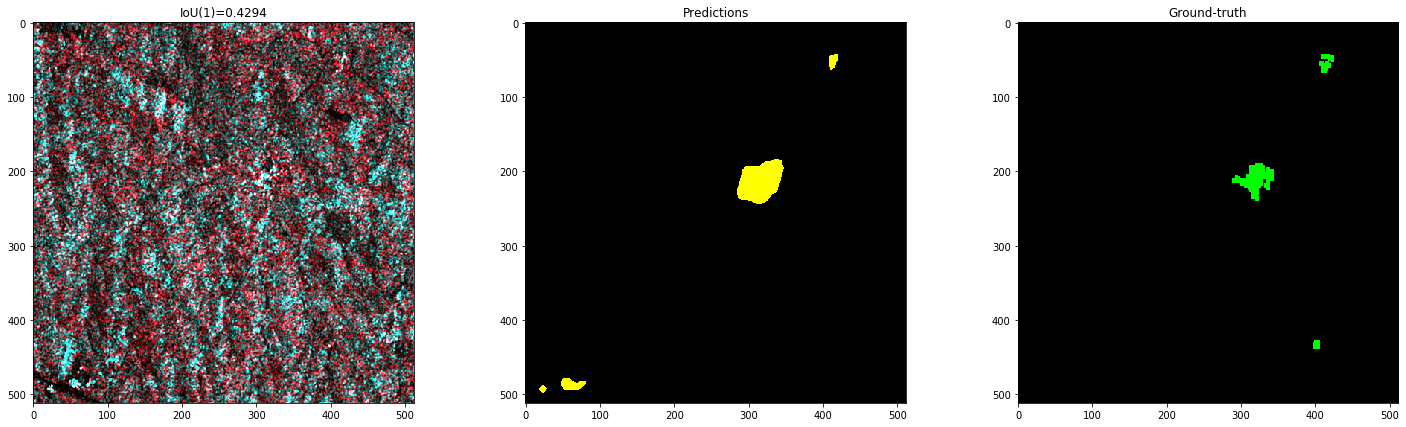

In [100]:
display_preds(y_preds, y, dp['image'])

Check on validation datapoint

In [101]:
i = 1000
dp = val_ds[i]

In [102]:
xy = val_transforms(**dp)
x = xy['image'].to('cuda').unsqueeze(0)
y = xy['mask'].to('cuda').unsqueeze(0)

In [103]:
with torch.no_grad():
    y_preds = model(x)

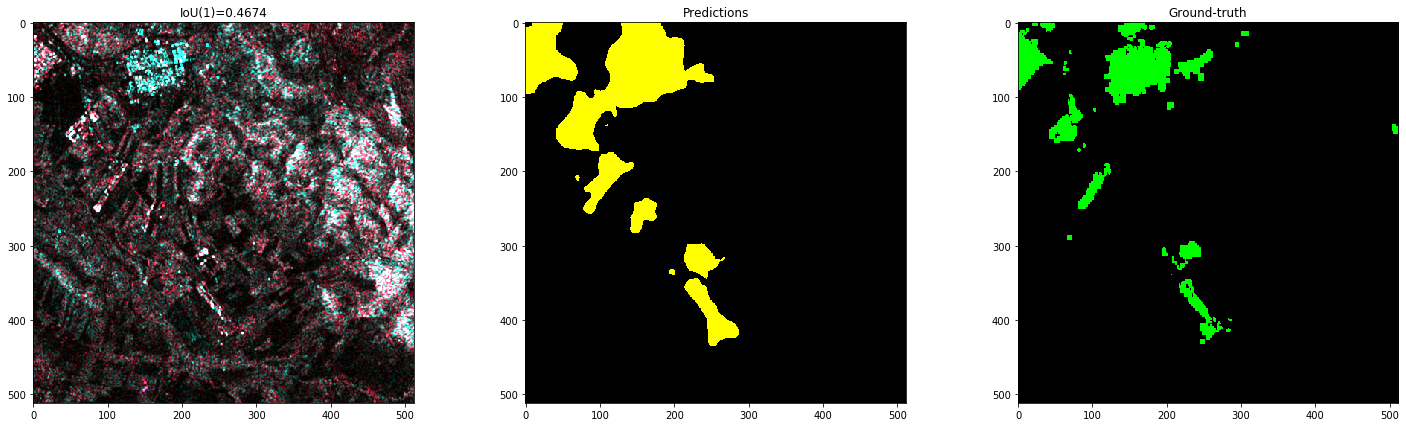

In [104]:
display_preds(y_preds, y, dp['image'])

In [125]:
i = 560
dp = val_ds[i]

In [126]:
xy = val_transforms(**dp)
x = xy['image'].to('cuda').unsqueeze(0)
y = xy['mask'].to('cuda').unsqueeze(0)

In [127]:
with torch.no_grad():
    y_preds = model(x)

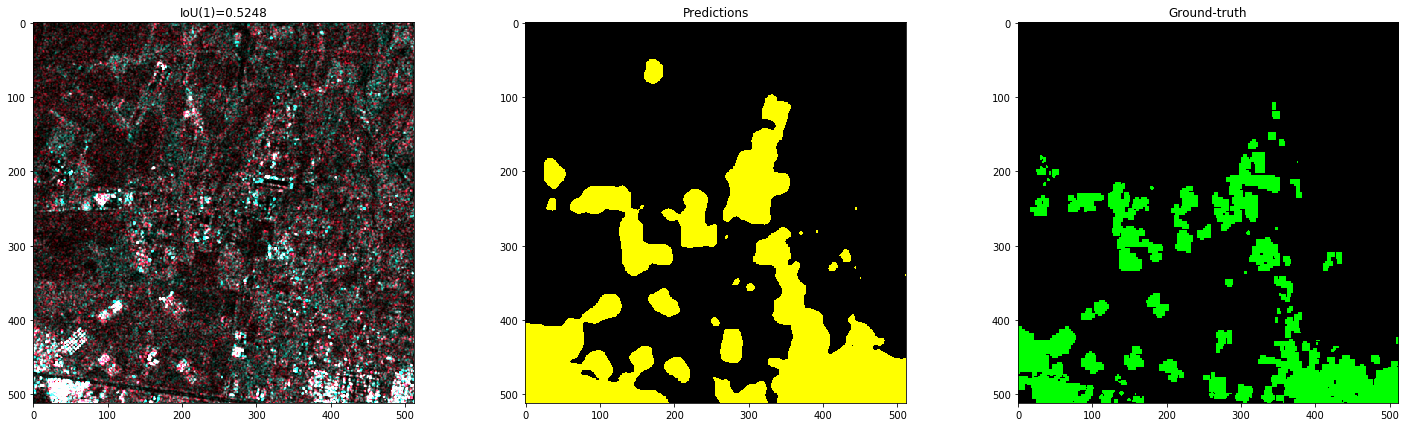

In [128]:
display_preds(y_preds, y, dp['image'])

In [129]:
i = 1560
dp = val_ds[i]

In [130]:
xy = val_transforms(**dp)
x = xy['image'].to('cuda').unsqueeze(0)
y = xy['mask'].to('cuda').unsqueeze(0)

In [131]:
with torch.no_grad():
    y_preds = model(x)

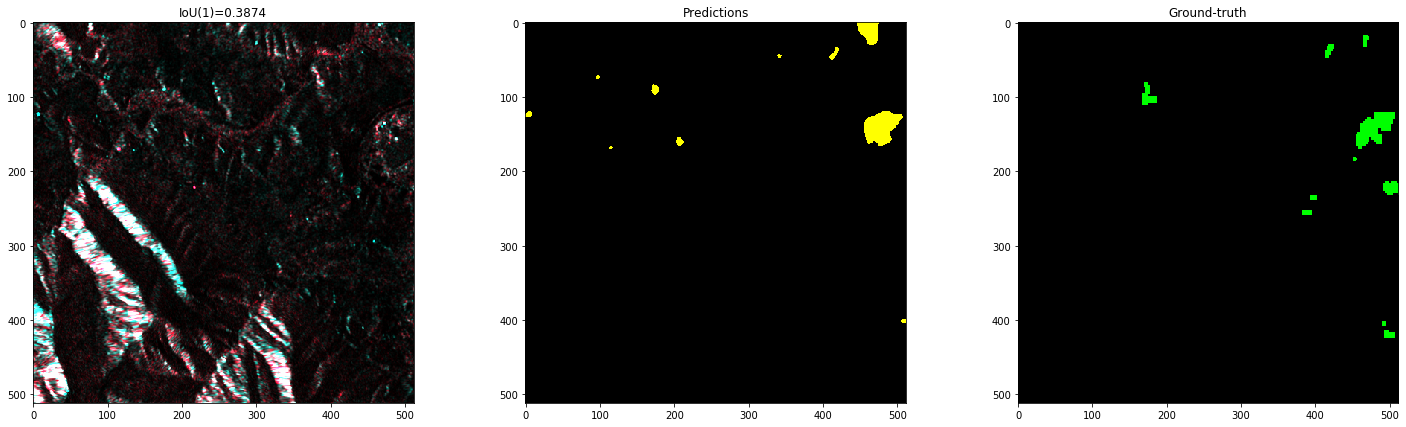

In [132]:
display_preds(y_preds, y, dp['image'])